In [142]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob

from scipy.signal import find_peaks


from IPython import display

# Feature generation

In [143]:
path = r'C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files'

In [183]:
el_sig = pd.read_csv(path + '\All FFT of electrode signal.csv', index_col=0)
om_sig = pd.read_csv(path + '\All FFT of optical signal.csv', index_col=0)

In [319]:
el_features = pd.DataFrame()
om_features = pd.DataFrame()

In [320]:
#count number of peaks for th% threshold
def number_of_peaks(df, th):
    all_props = []

    for col in df.columns[::2]:
        _, properties = find_peaks(df[col], height=0)
        all_props.append(properties)
    
    num_of_peaks = []
    
    for i in range(len(all_props)):
        max_height = np.max(all_props[i]['peak_heights'])
        peaks, _ = find_peaks(df[df.columns[::2]].iloc[:,i], height=th*max_height)
        num = peaks.shape[0]
        num_of_peaks.append(num)
    num_of_peaks = pd.DataFrame(num_of_peaks, columns=['#peaks_' + str(th)])
    return(num_of_peaks)

In [325]:
np.argmax(el_sig.iloc[:,0])

C:\Users\ecath\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


'68'

In [321]:
el_num_5 = number_of_peaks(el_sig, 0.05)
el_num_10 = number_of_peaks(el_sig, 0.1)
el_features = pd.concat([el_features, el_num_5, el_num_10], axis=1)

In [322]:
el_features.head()

,#peaks_0.05,#peaks_0.1
0,24,12
1,15,5
2,16,6
3,19,7
4,9,4


In [128]:
np.count_nonzero(el_peaks[0])

47

In [125]:
el_props[0]

{'left_bases': array([  0,   0,   8,   8,  16,  19,  21,  21,  27,  30,  33,  35,  37,
         41,  46,  46,  46,  53,  55,  55,  55,  72,  77,  77,  83,  83,
         88,  90,  88,  97,  97, 106, 110, 112, 114, 117, 124, 124, 130,
         97, 141, 143, 145, 149, 153, 155, 158], dtype=int64),
 'left_ips': array([  1.72761896,   3.31477032,   8.80308859,   8.53872155,
         16.61308555,  19.5       ,  22.56037971,  25.13013684,
         27.5       ,  30.5       ,  33.5       ,  35.5       ,
         38.60742162,  41.61950596,  46.94845314,  48.46226716,
         50.93647466,  53.5       ,  57.12626539,  60.64069378,
         66.55236896,  72.5       ,  77.69963976,  81.4280929 ,
         83.92284952,  83.55791628,  88.66341173,  90.5       ,
         92.28911449,  99.49600565, 101.32115101, 107.45525927,
        110.5       , 112.5       , 114.5       , 117.52062669,
        126.07835889, 128.49427459, 130.92935585, 135.36831894,
        141.5       , 143.5       , 145.5       , 14

In [129]:
np.max(el_props[0]['peak_heights'])
# el_props[0]['peak_heights'][-4:]


0.013463587025090335

In [79]:
peaks

array([  4,   7,  11,  17,  20,  22,  24,  28,  30,  33,  36,  39,  42,
        44,  47,  50,  55,  58,  60,  62,  64,  66,  68,  70,  78,  88,
        90,  94,  96, 100, 102, 104, 106, 108, 111, 113, 118, 121, 123,
       128, 131, 133, 137, 139, 141, 143, 145, 147, 149, 153, 156],
      dtype=int64)

dict_keys(['peak_heights'])

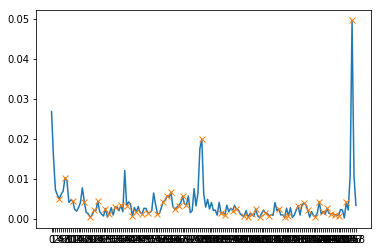

In [100]:
plt.plot(el_sig.iloc[:-42,78])
plt.plot(peaks, el_sig.iloc[:-42,78][peaks], "x")
plt.show()
